## 1 Data Loading and Analysis

In [36]:
import pandas as pd
import numpy as np
from sklearn.model_selection import TimeSeriesSplit, ParameterGrid
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.base import clone

# Read training and testing data, using the first column as the row index and the first row as the column names
train_data = pd.read_excel('https://github.com/zhentaoshi/Econ5821/raw/main/data_example/US_PCE_training.xlsx', index_col=0)
test_data = pd.read_excel('https://github.com/zhentaoshi/Econ5821/raw/main/data_example/US_PCE_testing_fake.xlsx', index_col=0)

# Extract PCE data
train_pce = train_data.iloc[0, :] 
test_pce = test_data.iloc[0, :] 

# Combine PCE data and calculate the inflation rate
combined_pce = pd.concat([train_pce, test_pce]).astype(float)
combined_inflation_rate = np.log(combined_pce).diff() * 12  
combined_inflation_rate = combined_inflation_rate.dropna()

# Split the training and testing inflation rates
train_inflation_rate = combined_inflation_rate.iloc[:len(train_pce)-1]
test_inflation_rate = combined_inflation_rate.iloc[len(train_pce)-1:]

# Extract feature variables
train_features = train_data.iloc[4:].T 
test_features = test_data.iloc[3:].T

combined_features = pd.concat([train_features, test_features]).astype(float)
combined_predictors = np.log(combined_features).diff() * 12
combined_predictors = combined_predictors.dropna()

train_predictors = combined_predictors.iloc[:len(train_features)-1,:] 
test_predictors = combined_predictors.iloc[len(train_features)-1:,]

# Normalize features
scaler = StandardScaler()
train_predictors_scaled = scaler.fit_transform(train_predictors)
test_predictors_scaled = scaler.transform(test_predictors)
train_predictors_scaled = pd.DataFrame(train_predictors_scaled,index=train_predictors.index,columns=train_predictors.columns)
test_predictors_scaled = pd.DataFrame(test_predictors_scaled,index=test_predictors.index,columns=test_predictors.columns)

## 2 Model Training

### 2.1 AR(1)

#### 2.1.1 Direct Forecast

In-sample MSE for 1-Month Model: 0.00043457980266529587
In-sample MSE for 3-Month Model: 0.0006144393178415042
In-sample MSE for 12-Month Model: 0.0006887413346311211


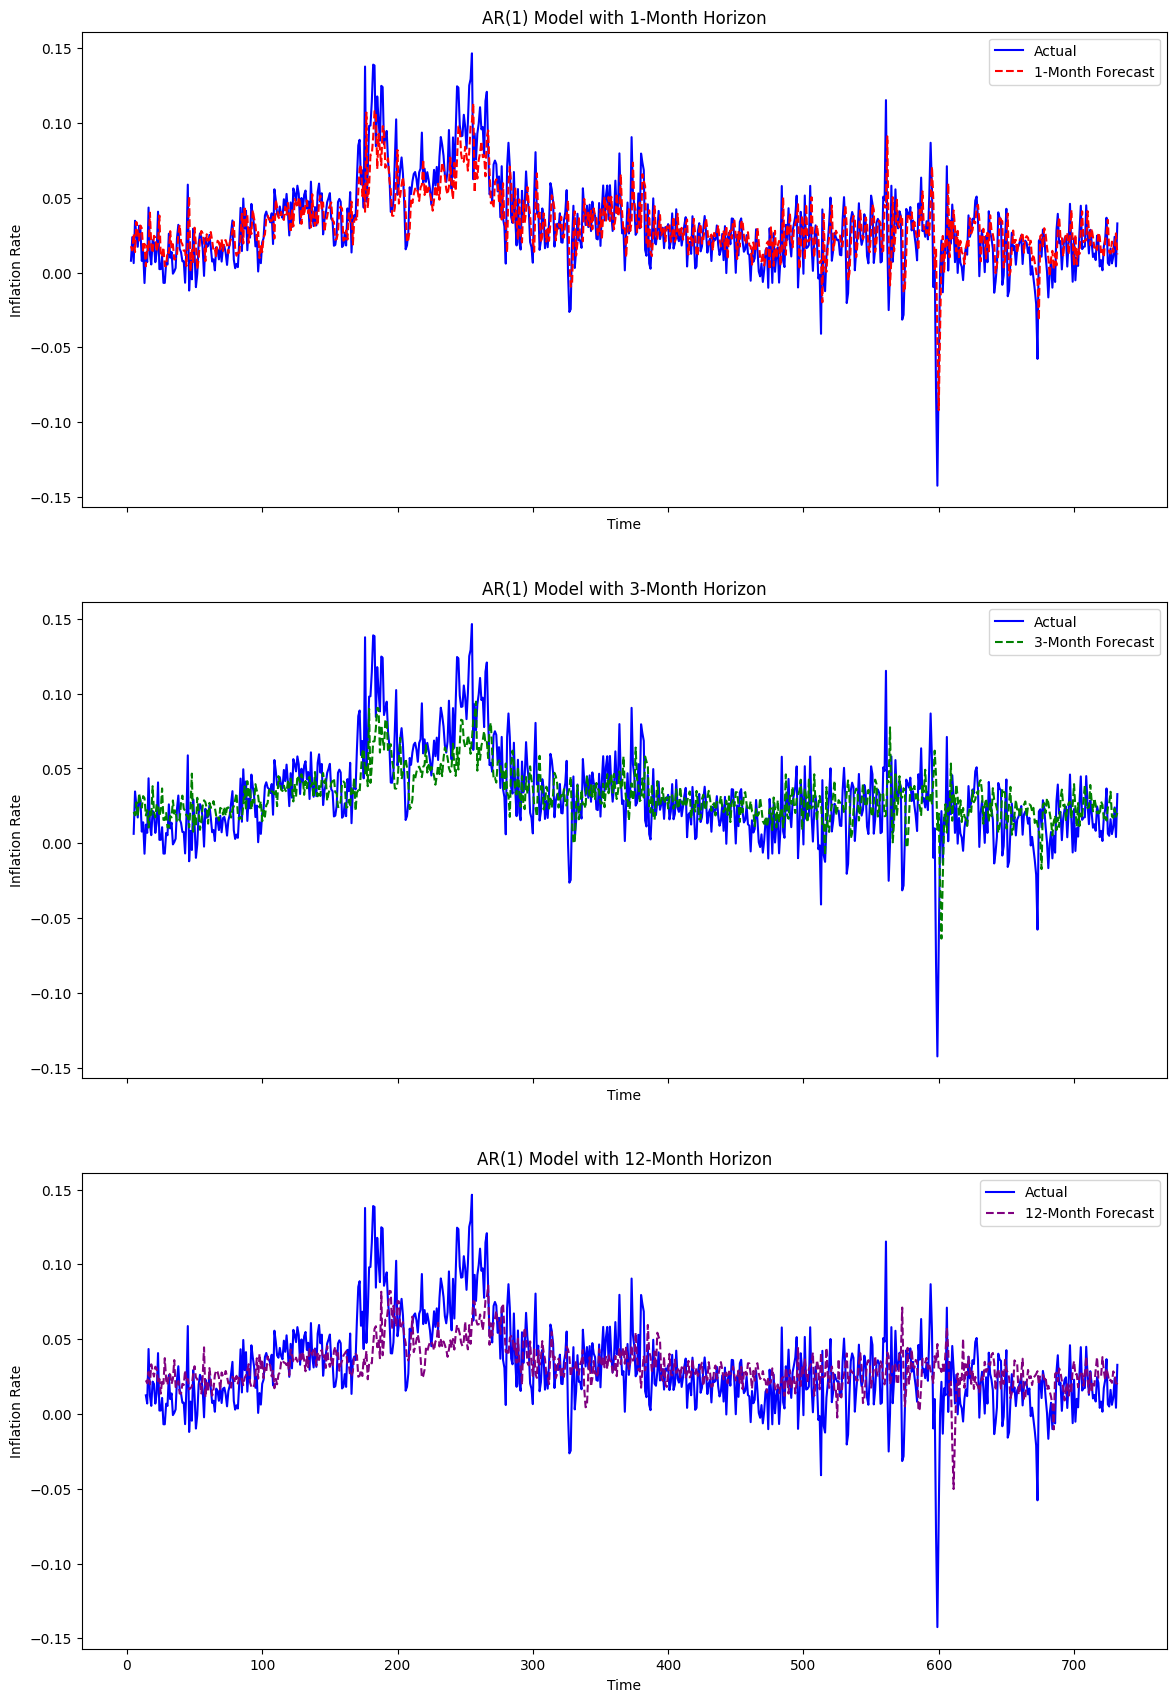

In [7]:
import statsmodels.api as sm

# Fit AR1 models with different horizons
def fit_ar1_model(data, horizons):
    y = data[horizons:]
    X = data.shift(horizons)[horizons:]
    X = sm.add_constant(X)
    model = sm.OLS(y, X)
    results = model.fit()
    
    return results

ar1_model_1m = fit_ar1_model(train_inflation_rate, 1)
ar1_model_3m = fit_ar1_model(train_inflation_rate, 3)
ar1_model_12m = fit_ar1_model(train_inflation_rate, 12)

# Visualizing In-Sample Fit
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(14, 21), sharex=True)
for ax, model, horizon, color in zip(axes, [ar1_model_1m, ar1_model_3m, ar1_model_12m], [1, 3, 12], ['red', 'green', 'purple']):
    predictions = model.predict(sm.add_constant(train_inflation_rate.shift(horizon)[horizon:]))
    ax.plot(train_inflation_rate.index[horizon:], train_inflation_rate[horizon:], label='Actual', color='blue')
    ax.plot(train_inflation_rate.index[horizon:], predictions, label=f'{horizon}-Month Forecast', linestyle='--', color=color)
    ax.set_title(f'AR(1) Model with {horizon}-Month Horizon')
    ax.set_xlabel('Time')
    ax.set_ylabel('Inflation Rate')
    ax.legend()
    print(f'In-sample MSE for {horizon}-Month Model:', mean_squared_error(train_inflation_rate[horizon:], predictions))

plt.show()

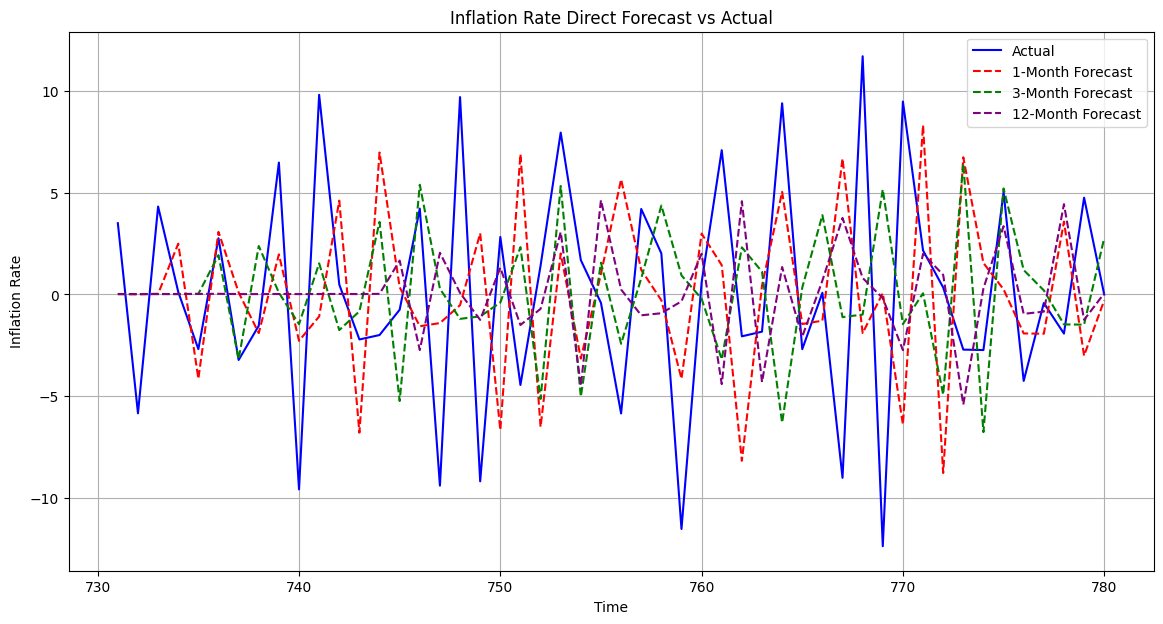

Out-of-sample MSE for 1-Month Model: 51.62356891748666
Out-of-sample MSE for 3-Month Model: 44.117333428285754
Out-of-sample MSE for 12-Month Model: 38.23845137748724


In [8]:
# Predicting and plotting out-of-sample forecasts
start_index = len(train_inflation_rate)  
end_index = start_index + len(test_inflation_rate)  

predictions_1m = []
predictions_3m = []
predictions_12m = []

for i in range(start_index, end_index):
        pred_1m = ar1_model_1m.predict([1, combined_inflation_rate[i - 1]])[0]
        predictions_1m.append(pred_1m)

        pred_3m = ar1_model_3m.predict([1, combined_inflation_rate[i - 3]])[0]
        predictions_3m.append(pred_3m)


        pred_12m = ar1_model_12m.predict([1, combined_inflation_rate[i - 12]])[0]
        predictions_12m.append(pred_12m)

plt.figure(figsize=(14, 7))
actuals = combined_inflation_rate[start_index:end_index]
plt.plot(range(start_index, end_index), actuals, label='Actual', color='blue')
plt.plot(range(start_index, end_index), predictions_1m, label='1-Month Forecast', color='red', linestyle='--')
plt.plot(range(start_index, end_index), predictions_3m, label='3-Month Forecast', color='green', linestyle='--')
plt.plot(range(start_index, end_index), predictions_12m, label='12-Month Forecast', color='purple', linestyle='--')
plt.title('Inflation Rate Direct Forecast vs Actual')
plt.xlabel('Time')
plt.ylabel('Inflation Rate')
plt.legend()
plt.grid(True)
plt.show()

# Print out-of-sample MSE
print('Out-of-sample MSE for 1-Month Model:', mean_squared_error(actuals, predictions_1m))
print('Out-of-sample MSE for 3-Month Model:', mean_squared_error(actuals, predictions_3m))
print('Out-of-sample MSE for 12-Month Model:', mean_squared_error(actuals, predictions_12m))

#### 2.1.2 Recursive Forecast

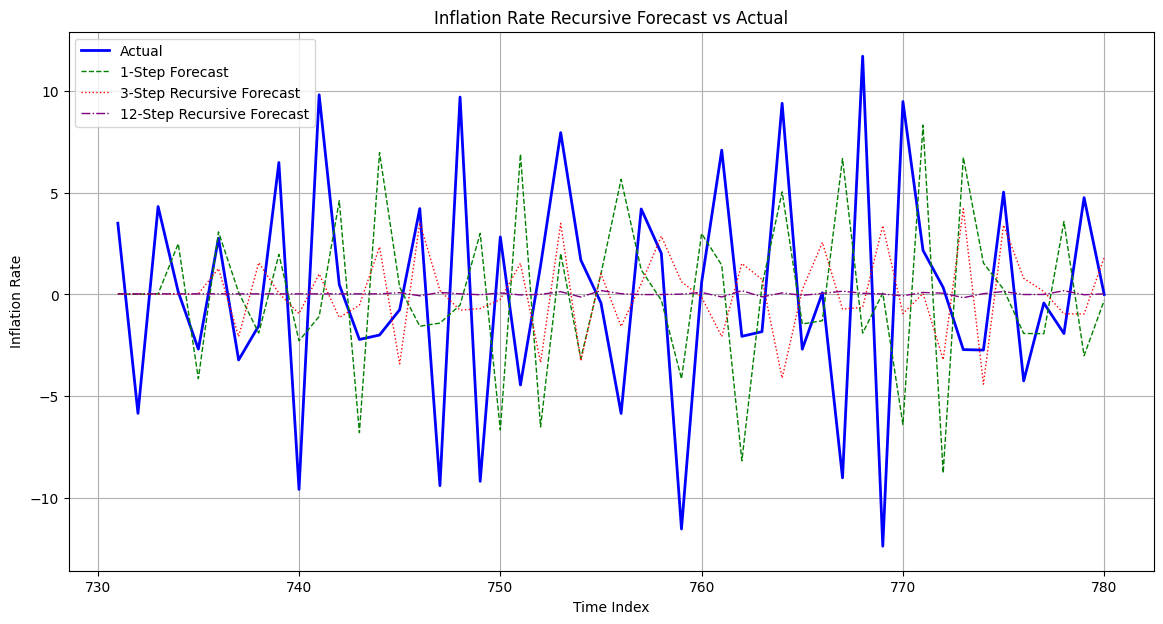

Out-of-sample MSE for 1-step: 51.62356891748666
Out-of-sample MSE for 3-step: 37.83396564637493
Out-of-sample MSE for 12-step: 32.19392366102182


In [9]:
ar1_model = ar1_model_1m

def recursive_forecast(model, start_value, steps):
    current_value = start_value
    for _ in range(steps):
        next_value = model.predict([1, current_value])[0]
        current_value = next_value
    return current_value

start_index = len(train_inflation_rate) 
end_index = start_index + len(test_inflation_rate) 

one_step_results = []
three_step_results = []
twelve_step_results = []

for t in range(start_index, end_index):
    one_step_forecast = recursive_forecast(ar1_model, combined_inflation_rate[t - 1], 1)
    one_step_results.append(one_step_forecast)
    
    three_step_forecast = recursive_forecast(ar1_model, combined_inflation_rate[t - 3], 3)
    three_step_results.append(three_step_forecast)

    twelve_step_forecast = recursive_forecast(ar1_model, combined_inflation_rate[t - 12], 12)
    twelve_step_results.append(twelve_step_forecast)

plt.figure(figsize=(14, 7))
plt.plot(range(start_index, end_index), combined_inflation_rate[start_index:end_index], label='Actual', color='blue', linewidth=2)
plt.plot(range(start_index, end_index), one_step_results, label='1-Step Forecast', color='green', linestyle='--', linewidth=1)
plt.plot(range(start_index, end_index), three_step_results, label='3-Step Recursive Forecast', color='red', linestyle=':', linewidth=1)
plt.plot(range(start_index, end_index), twelve_step_results, label='12-Step Recursive Forecast', color='purple', linestyle='-.', linewidth=1)
plt.title('Inflation Rate Recursive Forecast vs Actual')
plt.xlabel('Time Index')
plt.ylabel('Inflation Rate')
plt.legend()
plt.grid(True)
plt.show()

# Calculating and displaying Out-of-sample MSE
out_of_sample_mse_1 = mean_squared_error(test_inflation_rate, one_step_results)
out_of_sample_mse_3 = mean_squared_error(test_inflation_rate, three_step_results)
out_of_sample_mse_12 = mean_squared_error(test_inflation_rate, twelve_step_results)
print('Out-of-sample MSE for 1-step:', out_of_sample_mse_1)
print('Out-of-sample MSE for 3-step:', out_of_sample_mse_3)
print('Out-of-sample MSE for 12-step:', out_of_sample_mse_12)

### 2.2 LASSO

#### 2.2.1 Model Training and In-Sample Fitting

Selected optimal alpha value: 0.000720


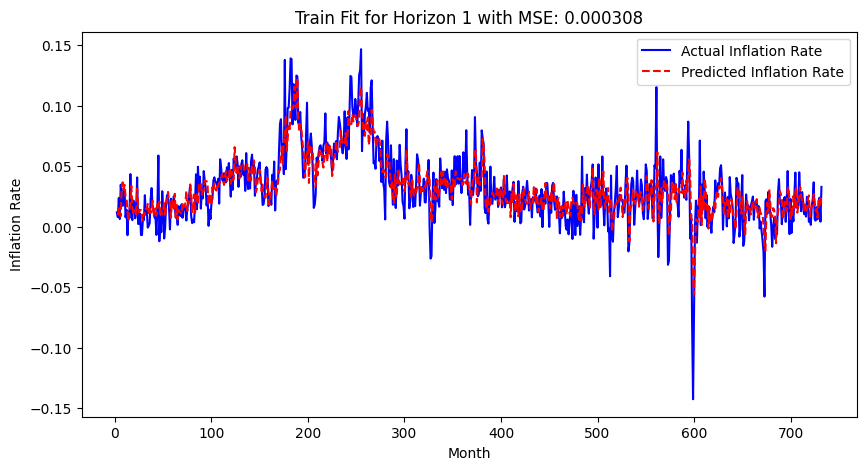

Selected optimal alpha value: 0.000848


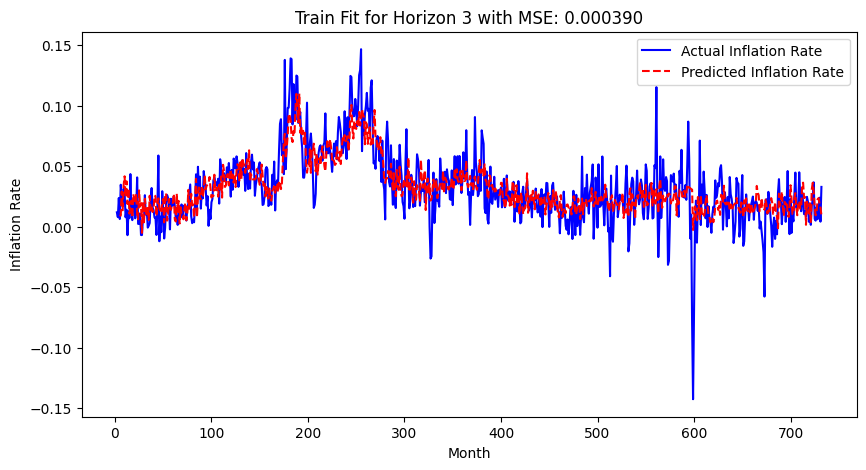

Selected optimal alpha value: 0.001638


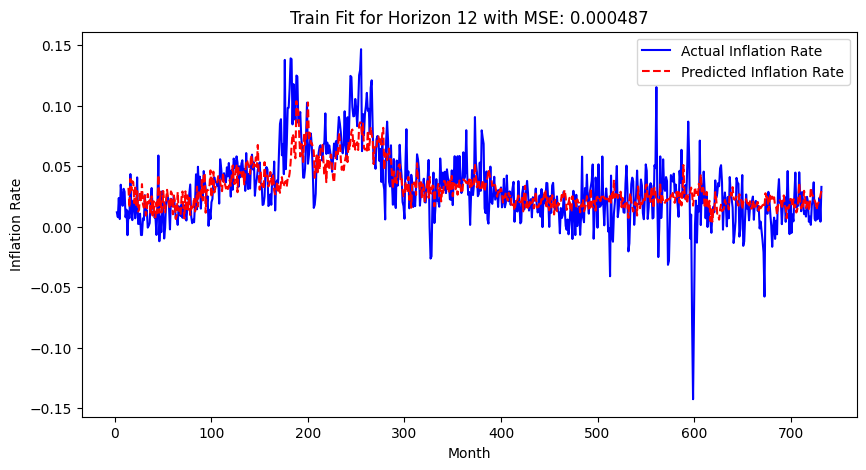

In [18]:
from sklearn.linear_model import LassoCV

def prepare_data_for_LASSO(horizon, train_inflation, predictors):
    # Create datasets of lagged inflation rates and other predictors
    X_inflation_lag = train_inflation.shift(horizon).dropna()  # Lagged inflation rate
    X_predictors_lag = predictors.shift(horizon).dropna()  # Lagged other predictors
    y = train_inflation.iloc[horizon:]  # Current inflation rate

    # Combine lagged inflation rates and other predictors
    X = pd.concat([X_inflation_lag, X_predictors_lag], axis=1).iloc[:len(y), :]
    return X, y

alphas = np.logspace(-4, -0.5, 50) # Define a range of alphas

def train_lasso_model(X, y, n_splits):
    # Use TimeSeriesSplit for time-series cross-validation
    tscv = TimeSeriesSplit(n_splits=n_splits)
    lasso_model = LassoCV(alphas=alphas, cv=tscv, random_state=0, max_iter=10000).fit(X, y)
    return lasso_model

def plot_predictions(train_inflation_rate, y_pred, horizon, title):
    plt.figure(figsize=(10, 5))
    y_pred_full = pd.Series([np.nan] * len(train_inflation_rate), index=train_inflation_rate.index)
    y_pred_full.iloc[horizon:] = y_pred
    
    plt.plot(train_inflation_rate, label='Actual Inflation Rate', color='blue')
    plt.plot(y_pred_full, label='Predicted Inflation Rate', linestyle='--', color='red')
    plt.title(title)
    plt.xlabel('Month')
    plt.ylabel('Inflation Rate')
    plt.legend()
    plt.show()

horizons = [1, 3, 12]
models_lasso = {}
n_splits = 5

for horizon in horizons:
    X_lag, y_lag = prepare_data_for_LASSO(horizon, train_inflation_rate, train_predictors_scaled)
    model_lasso = train_lasso_model(X_lag, y_lag, n_splits)
    models_lasso[horizon] = model_lasso
    print(f"Selected optimal alpha value: {model_lasso.alpha_:.6f}")
    # Prediction
    y_pred = model_lasso.predict(X_lag)
    
    train_mse = mean_squared_error(y_lag, y_pred)
    
    # Plot
    plot_predictions(train_inflation_rate, y_pred, horizon, f'Train Fit for Horizon {horizon} with MSE: {train_mse:.6f}')

#### 2.2.2 Pseudo Out-of-Sample Prediction

1-month-ahead model out-of-sample MSE: 32.0235105131593


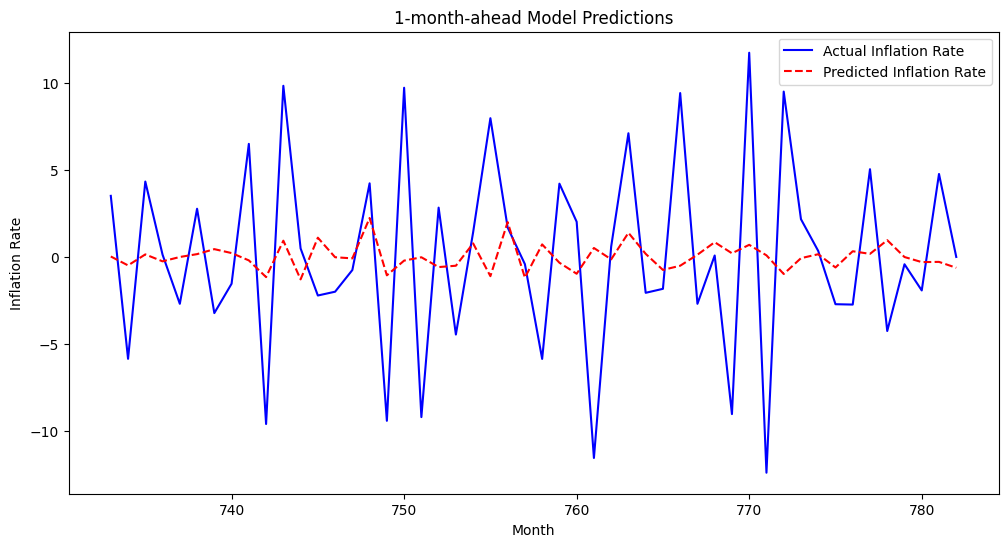

3-month-ahead model out-of-sample MSE: 34.016680538744694


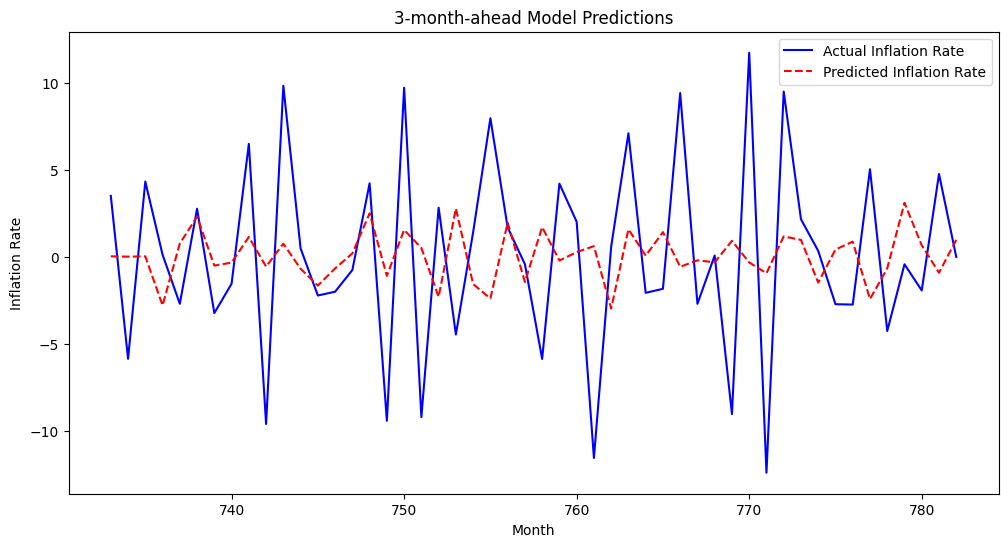

12-month-ahead model out-of-sample MSE: 31.850931776687275


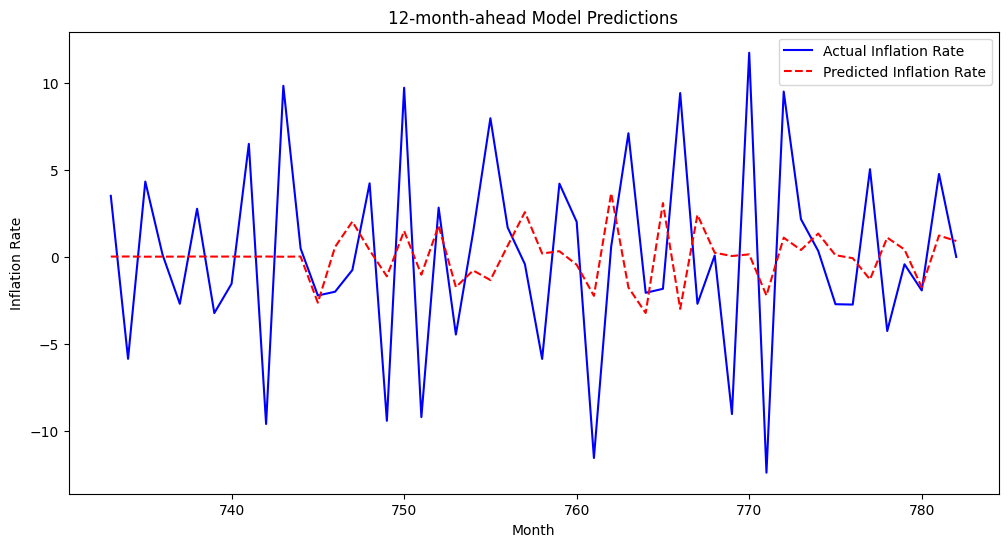

In [17]:
def plot_test_predictions(y_true, y_pred, title):
    plt.figure(figsize=(12, 6))
    plt.plot(y_true, label='Actual Inflation Rate', color='blue')
    plt.plot(y_true.index, y_pred, label='Predicted Inflation Rate', linestyle='--', color='red')
    plt.title(title)
    plt.xlabel('Month')
    plt.ylabel('Inflation Rate')
    plt.legend()
    plt.show()

# Store each model's prediction results
test_predictions = {}
mse_scores = {}

for horizon, model_lasso in models_lasso.items():
    # Extract the tail part of the training data to fulfill the lag requirement
    train_inflation_tail = train_inflation_rate[-horizon:]
    train_predictors_tail = train_predictors_scaled.tail(horizon)
    
    # Concatenate training tail and test data to create a full test dataset
    test_inflation_rate_full = pd.concat([train_inflation_tail, test_inflation_rate])
    test_predictors_full = pd.concat([train_predictors_tail, pd.DataFrame(test_predictors_scaled, index=test_predictors.index)])

    # Prepare data
    X_test, y_test_actual = prepare_data_for_LASSO(horizon, test_inflation_rate_full, test_predictors_full)
    
    # Perform predictions
    y_pred = model_lasso.predict(X_test)
    test_predictions[horizon] = y_pred
    
    # Calculate MSE
    mse = mean_squared_error(y_test_actual, y_pred)
    mse_scores[horizon] = mse
    print(f"{horizon}-month-ahead model out-of-sample MSE: {mse}")
    
    plot_test_predictions(test_inflation_rate, y_pred, f"{horizon}-month-ahead Model Predictions")

### 2.3 Adaptive LASSO

#### 2.3.1 Model Training and In-Sample Fitting

1-month-ahead model: MSE = 0.000482, Selected alpha = 0.053367


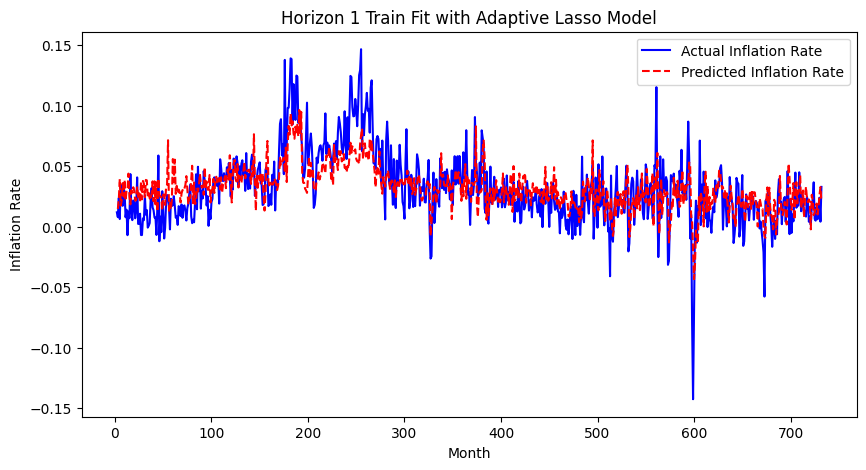

3-month-ahead model: MSE = 0.000457, Selected alpha = 0.008697


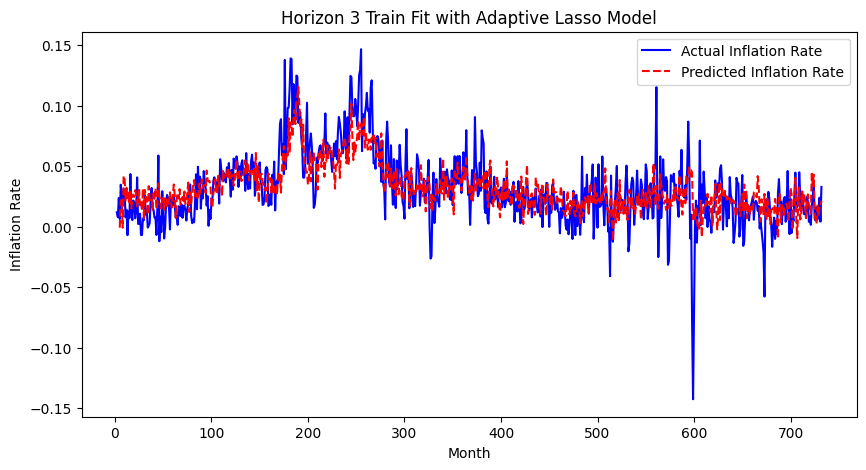

12-month-ahead model: MSE = 0.000548, Selected alpha = 0.020092


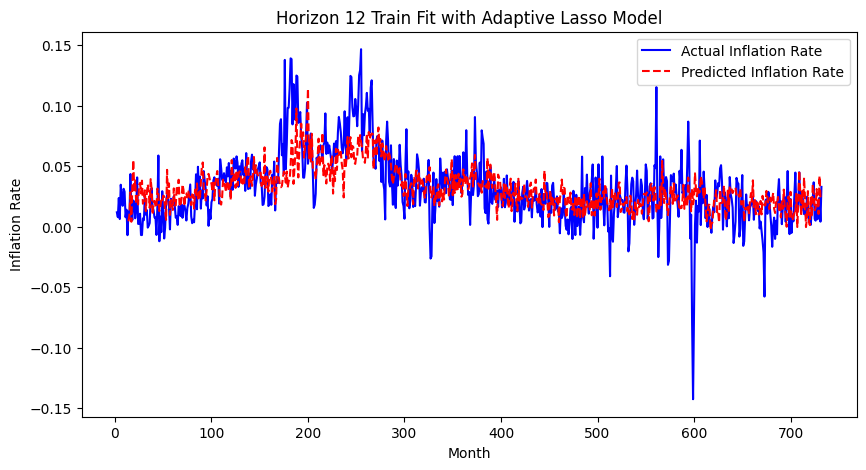

In [23]:
from sklearn.linear_model import LinearRegression

def get_ols_coefficients(X, y):
    # Fit an Ordinary Least Squares (OLS) linear model and return the coefficients
    ols = LinearRegression().fit(X, y)
    return ols.coef_

def train_adaptive_lasso(X, y, weights, n_splits, alphas):
    # Apply weights to features
    X_weighted = X.multiply(weights, axis=1)  # Multiply features by weights

    # Use time series cross-validation
    tscv = TimeSeriesSplit(n_splits=n_splits)
    model_adaptive_lasso = LassoCV(alphas=alphas, cv=tscv, max_iter=100000, random_state=0,tol=0.005).fit(X_weighted, y)
    return model_adaptive_lasso

alphas = np.logspace(-4, 2, 100)
models_adaptive_lasso = {}
mse_scores = {}
selected_alphas = {}

for horizon in horizons:
    X_lag, y_lag = prepare_data_for_LASSO(horizon, train_inflation_rate, train_predictors)
    # Compute weights (inverse of the absolute OLS coefficients)
    ols_coefficients = get_ols_coefficients(X_lag, y_lag)
    weights = 1 / np.abs(ols_coefficients)
    weights[np.isinf(weights)] = 1e8  # Handle infinite values

    model_adaptive_lasso = train_adaptive_lasso(X_lag, y_lag, weights, n_splits, alphas)
    models_adaptive_lasso[horizon] = model_adaptive_lasso
    
    y_pred_adaptive = model_adaptive_lasso.predict(X_lag.multiply(weights, axis=1))  # Apply the same weights to the predictors
    mse = mean_squared_error(y_lag, y_pred_adaptive)
    mse_scores[horizon] = mse
    
    selected_alphas[horizon] = model_adaptive_lasso.alpha_
    
    # Print MSE and selected alpha for each model
    print(f"{horizon}-month-ahead model: MSE = {mse:.6f}, Selected alpha = {model_adaptive_lasso.alpha_:.6f}")

    plot_predictions(train_inflation_rate, y_pred_adaptive, horizon, f'Horizon {horizon} Train Fit with Adaptive Lasso Model')

#### 2.3.2 Pseudo Out-of-Sample Prediction

1-month-ahead model out-of-sample MSE: 38.58011493422289


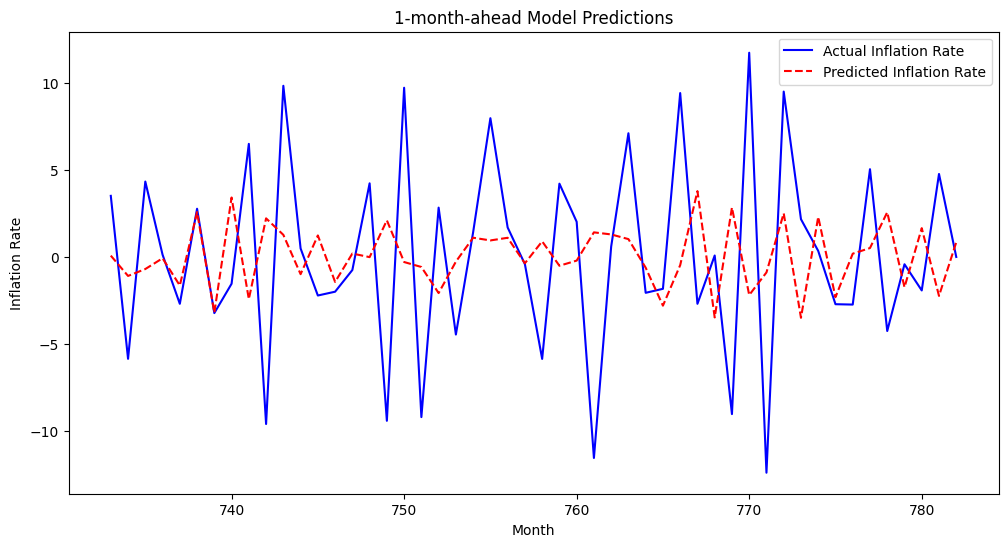

3-month-ahead model out-of-sample MSE: 55.74353629319688


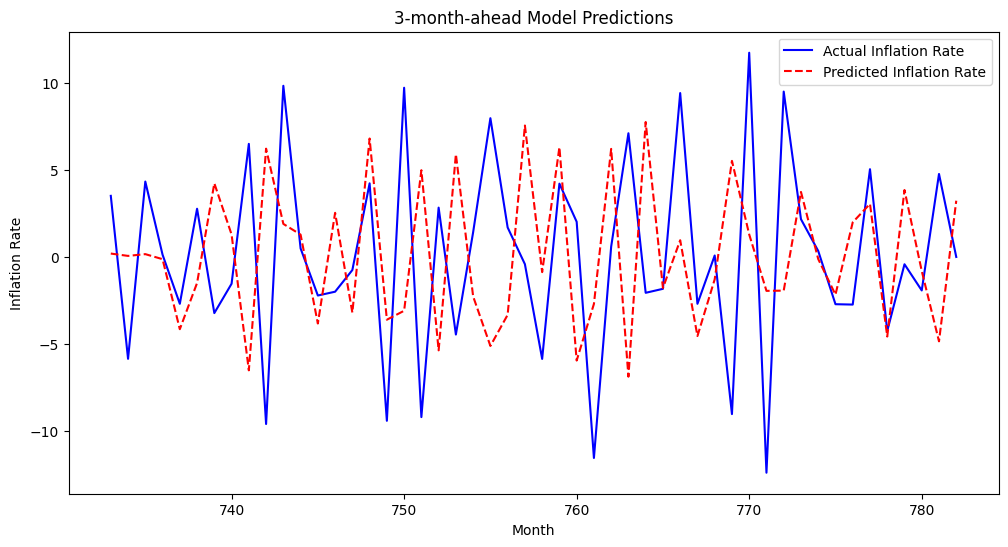

12-month-ahead model out-of-sample MSE: 31.233149226999977


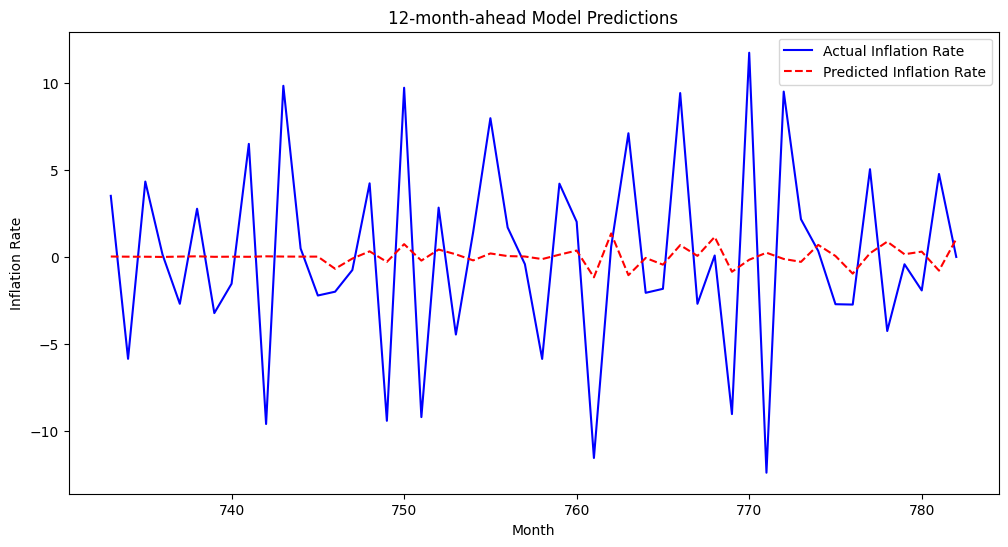

In [24]:
for horizon, model_adaptive_lasso in models_adaptive_lasso.items():
    train_inflation_tail = train_inflation_rate[-horizon:]
    train_predictors_tail = train_predictors.tail(horizon)
    test_inflation_rate_full = pd.concat([train_inflation_tail, test_inflation_rate])
    test_predictors_full = pd.concat([train_predictors_tail, test_predictors])

    X_test, y_test_actual = prepare_data_for_LASSO(horizon, test_inflation_rate_full, test_predictors_full)
    
    y_pred_adaptive = model_adaptive_lasso.predict(X_test.multiply(weights, axis=1))
    test_predictions[horizon] = y_pred_adaptive
    
    mse = mean_squared_error(y_test_actual, y_pred_adaptive)
    mse_scores[horizon] = mse
    print(f"{horizon}-month-ahead model out-of-sample MSE: {mse}")

    plot_test_predictions(test_inflation_rate, y_pred_adaptive, f"{horizon}-month-ahead Model Predictions")

### 2.4 SVR

#### 2.4.1 Model Training and In-Sample Fitting

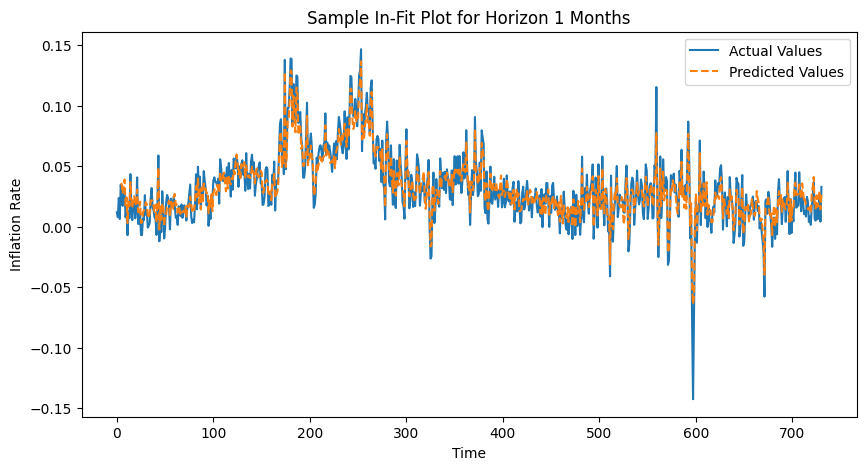

Horizon 1 months: Best Parameters: {'C': 0.1, 'epsilon': 0.01, 'gamma': 'auto'}
Horizon 1 months: MSE = 0.000084


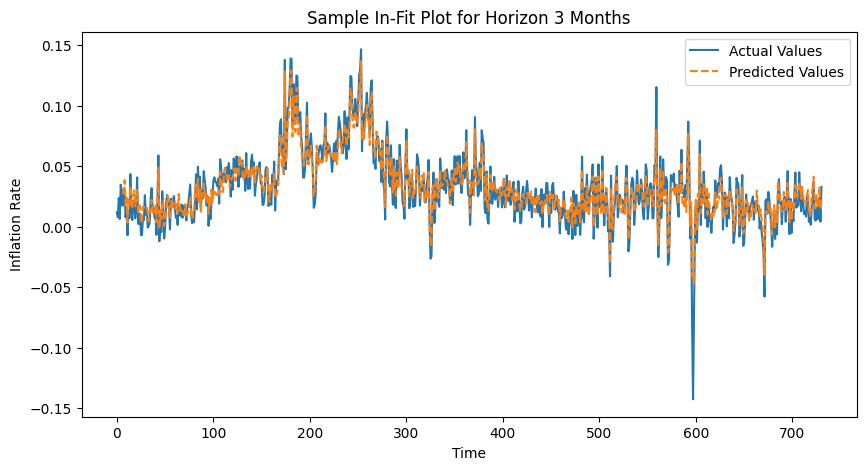

Horizon 3 months: Best Parameters: {'C': 0.1, 'epsilon': 0.01, 'gamma': 'auto'}
Horizon 3 months: MSE = 0.000093


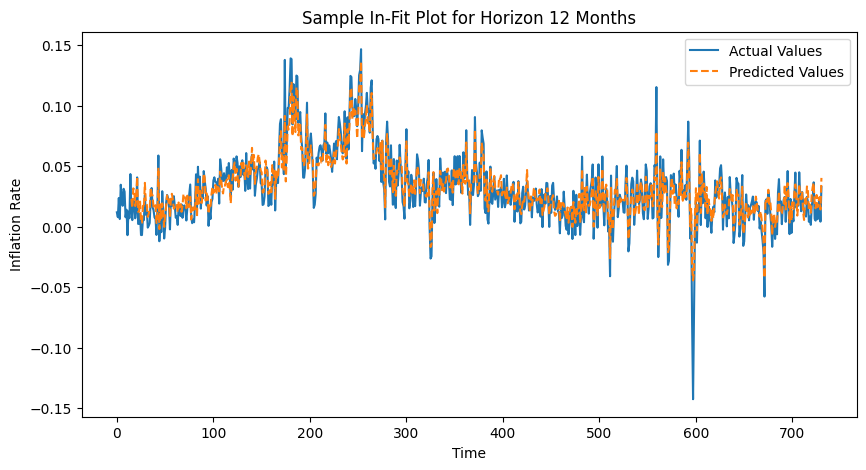

Horizon 12 months: Best Parameters: {'C': 0.1, 'epsilon': 0.01, 'gamma': 'auto'}
Horizon 12 months: MSE = 0.000100


In [30]:
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV

train_predictors_scaled = np.array(train_predictors_scaled)
test_predictors_scaled = np.array(test_predictors_scaled)

def prepare_data_for_svr(features, target, n_lags, horizon):
    X, y = [], []
    # Loop over the indices of the target array that allow for both lags and horizon
    for i in range(n_lags + horizon, len(target)):
        start_idx = i - horizon - n_lags
        end_idx = i - horizon
       
        feature_set = features[start_idx:end_idx].flatten()  # Lagged predictor features
        target_lags = target[start_idx:end_idx].flatten()  # Lagged values of the target variable
        X.append(np.hstack([feature_set, target_lags]))
        y.append(target[i])
    return np.array(X), np.array(y)

# Model training and evaluation for different horizons
horizons = [1, 3, 12]
n_lags = 3
models_svr = {}
mse_scores = {}

for horizon in horizons:
    X_train, y_train = prepare_data_for_svr(train_predictors_scaled, train_inflation_rate.values, n_lags, horizon)
    param_grid = {
        'C': [0.1, 1, 10],
        'epsilon': [0.01, 0.1, 0.5],
        'gamma': ['auto', 'scale', 0.01, 0.1]
    }
    tscv = TimeSeriesSplit(n_splits=5)
    grid_search = GridSearchCV(SVR(kernel='rbf'), param_grid, cv=tscv, scoring='neg_mean_squared_error')
    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_
    models_svr[horizon] = best_model
    y_pred = best_model.predict(X_train)
    mse = mean_squared_error(y_train, y_pred)
    mse_scores[horizon] = mse

    # Plotting actual vs predicted values
    plt.figure(figsize=(10, 5))
    plt.plot(range(len(train_inflation_rate)), train_inflation_rate, label='Actual Values')
    pred_start = n_lags + horizon
    plt.plot(range(pred_start, pred_start + len(y_pred)), y_pred, label='Predicted Values', linestyle='--')
    plt.title(f'Sample In-Fit Plot for Horizon {horizon} Months')
    plt.xlabel('Time')
    plt.ylabel('Inflation Rate')
    plt.legend()
    plt.show()

    print(f"Horizon {horizon} months: Best Parameters: {grid_search.best_params_}")
    print(f"Horizon {horizon} months: MSE = {mse:.6f}")

#### 2.4.2 Pseudo Out-of-Sample Prediction

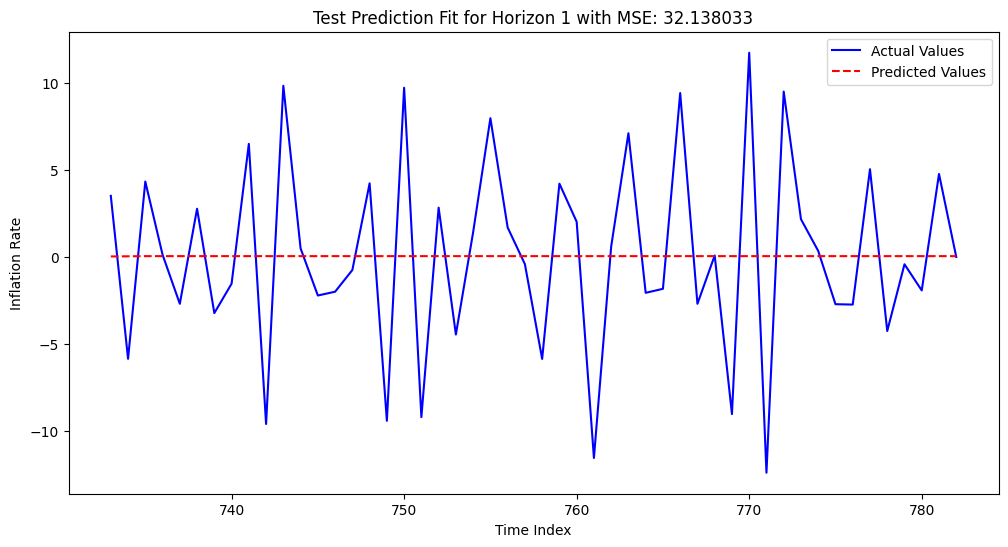

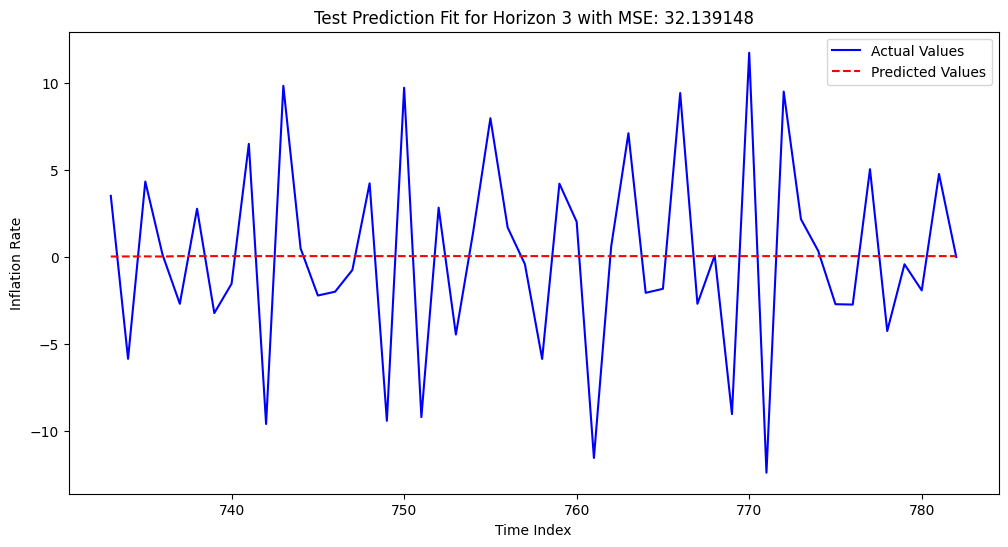

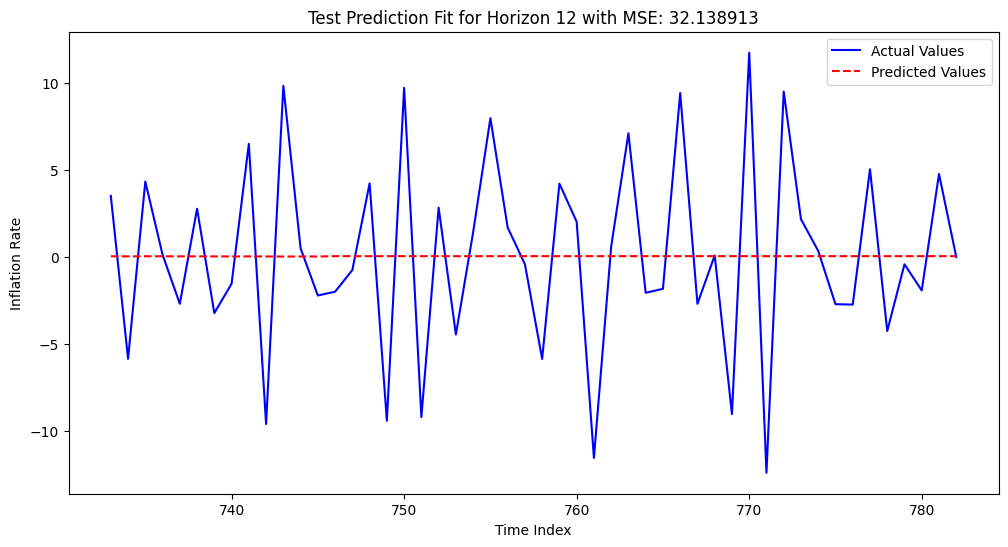

In [28]:
def prepare_test_data(train_features, train_target, test_features, test_target, n_lags, horizon):
    # Extend test features by including sufficient training set tail data to handle lag and horizon
    combined_features = np.vstack([train_features[-(n_lags + horizon):], test_features])
    combined_target = np.concatenate([train_target[-(n_lags + horizon):], test_target])
    
    X_test, y_test = [], []
    # Start index is after the initial n_lags + horizon to form a complete first set of features
    start_index = n_lags + horizon

    # Iterate through combined data to form feature and target sets for testing
    for i in range(start_index, len(combined_target)):
        start_idx = i - n_lags - horizon
        end_idx = i - horizon
        # Flatten feature sets to create a single array per sample
        feature_set = combined_features[start_idx:end_idx].flatten()
        target_lags = combined_target[start_idx:end_idx].flatten()
        
        X_test.append(np.hstack([feature_set, target_lags]))
        y_test.append(combined_target[i])

    return np.array(X_test), np.array(y_test)

test_mses = {}
for horizon in horizons:
    X_test, y_test = prepare_test_data(train_predictors_scaled, train_inflation_rate, test_predictors_scaled, test_inflation_rate, n_lags, horizon)
    model_svr = models_svr[horizon]  # Retrieve the model trained for this specific horizon
    
    y_pred_test = model_svr.predict(X_test)
    test_mses[horizon] = mean_squared_error(y_test, y_pred_test)

    end_idx = len(combined_inflation_rate)  
    start_idx = end_idx - 50  

    plt.figure(figsize=(12, 6))
    plt.plot(combined_inflation_rate.index[start_idx:end_idx], y_test, label='Actual Values', color='blue')
    plt.plot(combined_inflation_rate.index[start_idx:end_idx], y_pred_test, label='Predicted Values', linestyle='--', color='red')
    plt.title(f"Test Prediction Fit for Horizon {horizon} with MSE: {test_mses[horizon]:.6f}")
    plt.xlabel('Time Index')
    plt.ylabel('Inflation Rate')
    plt.legend()
    plt.show()

### 2.5 Random Forest

#### 2.5.1 Model Training and In-Sample Fitting

Horizon 1: Best CV MSE 0.0007638457073226545, Best Params {'max_depth': 10, 'n_estimators': 100}


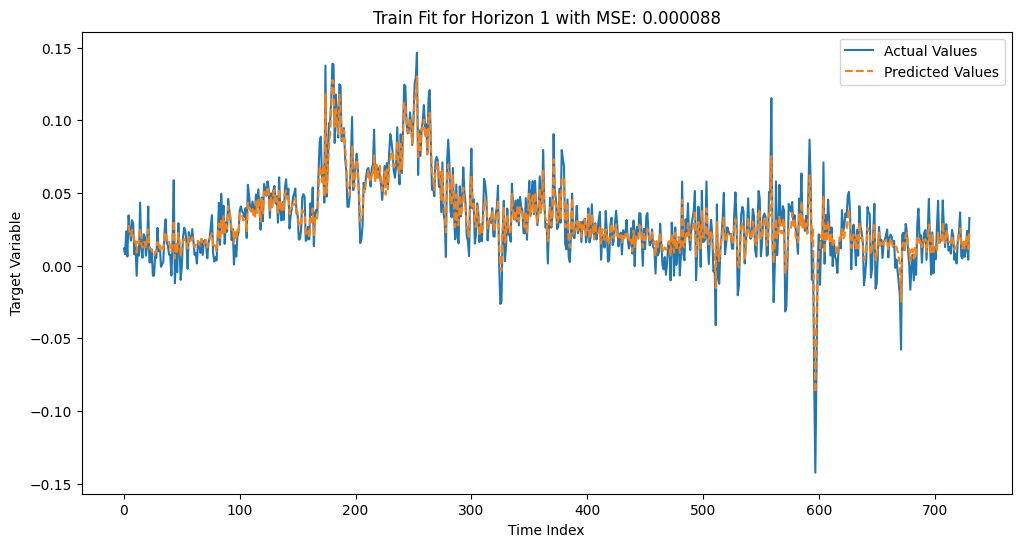

Horizon 3: Best CV MSE 0.0007663975987406811, Best Params {'max_depth': 10, 'n_estimators': 100}


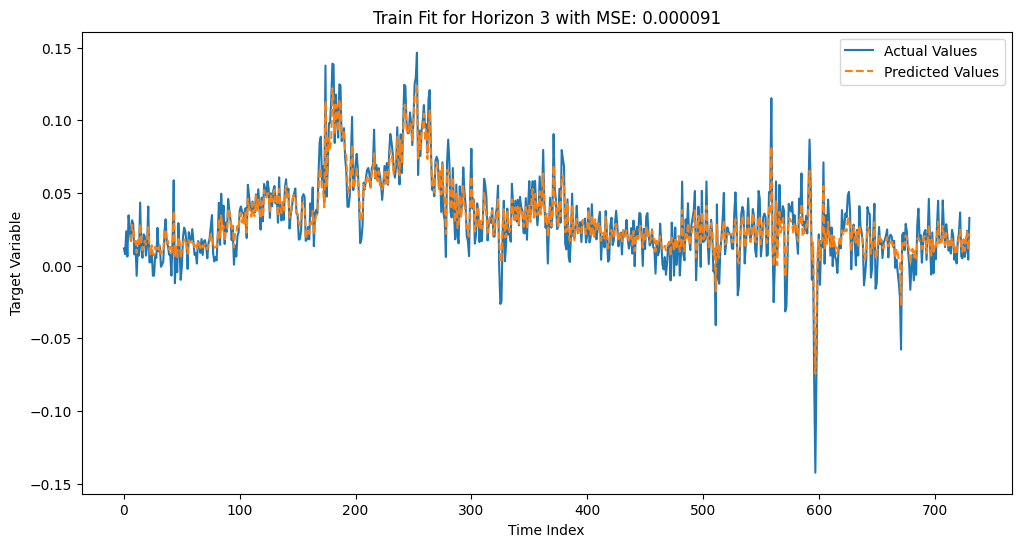

Horizon 12: Best CV MSE 0.0009153265259572076, Best Params {'max_depth': 10, 'n_estimators': 150}


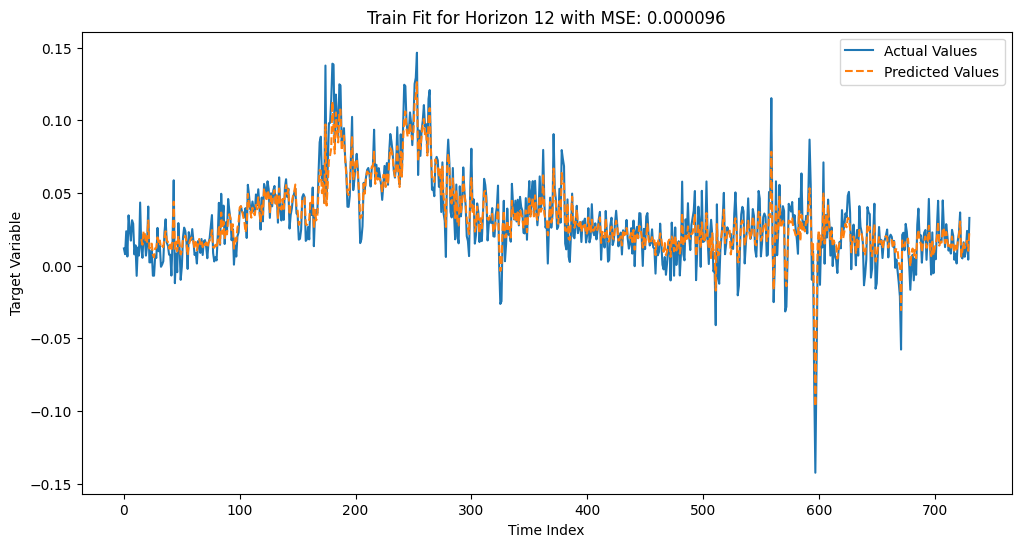

In [34]:
def prepare_data(features, target, n_lags, horizon):
    X, y = [], []
    # Loop over the indices of the target array that allow for both lags and horizon
    for i in range(n_lags + horizon, len(target)):
        start_idx = i - horizon - n_lags
        end_idx = i - horizon
        feature_set = features.iloc[start_idx:end_idx].to_numpy().flatten()  # Lagged predictor features
        target_lags = target.iloc[start_idx:end_idx].to_numpy().flatten()  # Lagged values of the target variable  
        X.append(np.hstack([feature_set, target_lags]))
        # Append the actual target value for the corresponding time point 'i' to the target list
        y.append(target.iloc[i])
    return np.array(X), np.array(y)
    
def perform_random_forest(X, y, n_splits, param_grid):
    # Initialize the Time Series Cross-Validator
    tscv = TimeSeriesSplit(n_splits=n_splits)
    best_score = float('inf')
    best_params = {}

    # Iterate over all possible combinations of parameters in the parameter grid
    for params in ParameterGrid(param_grid):
        model_random_forest = RandomForestRegressor(**params, random_state=42, n_jobs=-1)
        scores = []

        for train_idx, test_idx in tscv.split(X):
            X_train, y_train = X[train_idx], y[train_idx]
            X_test, y_test = X[test_idx], y[test_idx]
            model_random_forest.fit(X_train, y_train)
            y_pred = model_random_forest.predict(X_test)
            score = mean_squared_error(y_test, y_pred)
            scores.append(score)

        avg_score = np.mean(scores)
        if avg_score < best_score:
            best_score = avg_score
            best_params = params

    # Re-fit the model with the best parameters found on the entire dataset
    model_random_forest.set_params(**best_params)
    model_random_forest.fit(X, y)
    return model_random_forest, best_score, best_params

n_lags = 3
horizons = [1, 3, 12]

# Set the parameter grid for tuning the RandomForest model
param_grid = {
    'n_estimators': [50, 100, 150],  # Number of trees in the forest
    'max_depth': [10, 20, 30]  # Maximum depth of each tree
}
n_splits = 5

models_random_forest = {}
for horizon in horizons:
    X, y = prepare_data(train_predictors, train_inflation_rate, n_lags, horizon)
    model_random_forest, best_score, best_params = perform_random_forest(X, y, n_splits, param_grid)
    models_random_forest[horizon] = model_random_forest
    print(f"Horizon {horizon}: Best CV MSE {best_score}, Best Params {best_params}")

    # Predict on the training dataset to evaluate fit
    y_pred = model_random_forest.predict(X)

    # Calculate Mean Squared Error on the training dataset
    train_mse = mean_squared_error(y, y_pred)

    # Prepare a plot to visualize actual values and predictions
    plt.figure(figsize=(12, 6))
    plt.plot(range(len(train_inflation_rate)), train_inflation_rate, label='Actual Values')
    # Plot predictions with an offset
    pred_start = n_lags + horizon
    plt.plot(range(pred_start, pred_start + len(y_pred)), y_pred, label='Predicted Values', linestyle='--')
    plt.title(f'Train Fit for Horizon {horizon} with MSE: {train_mse:.6f}')
    plt.xlabel('Time Index')
    plt.ylabel('Target Variable')
    plt.legend()
    plt.show()

#### 2.5.2 Pseudo Out-of-Sample Prediction

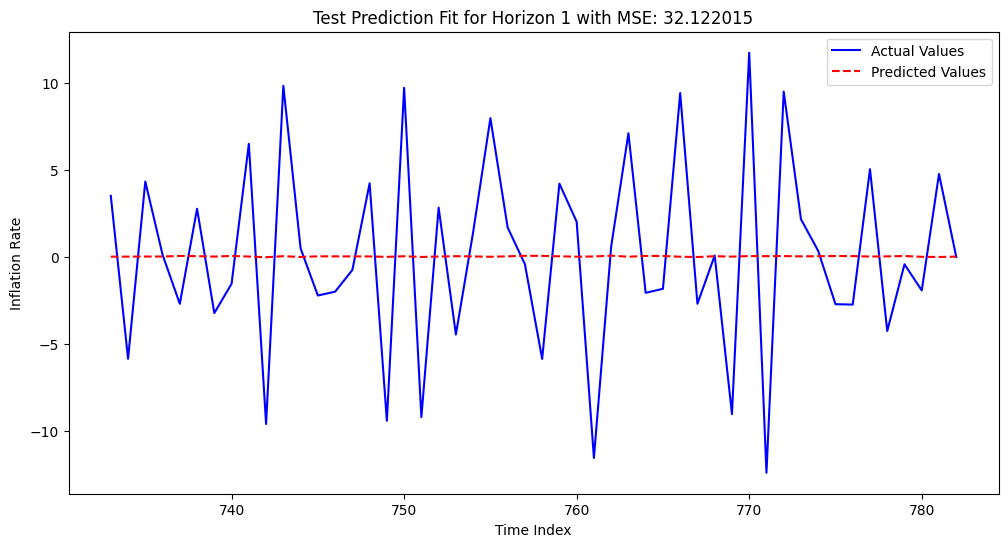

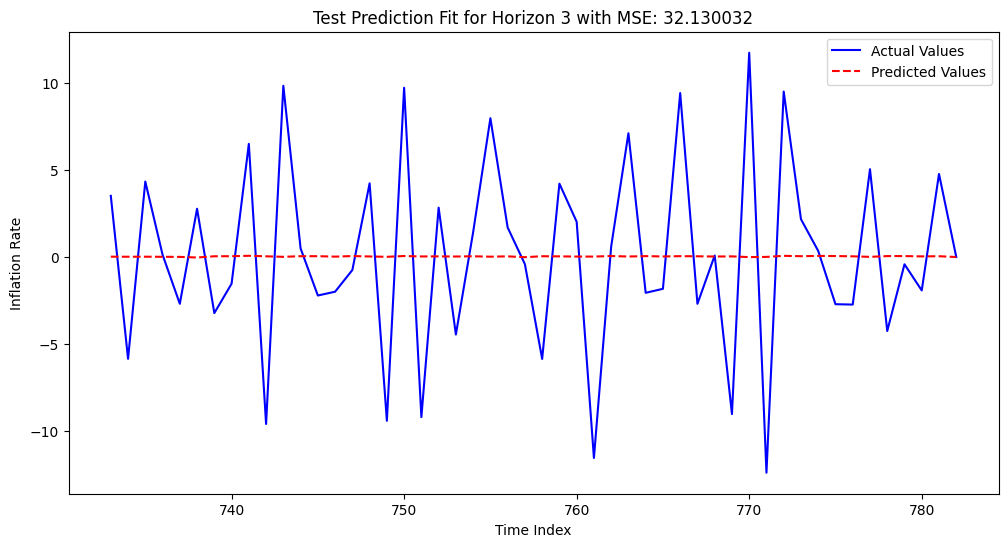

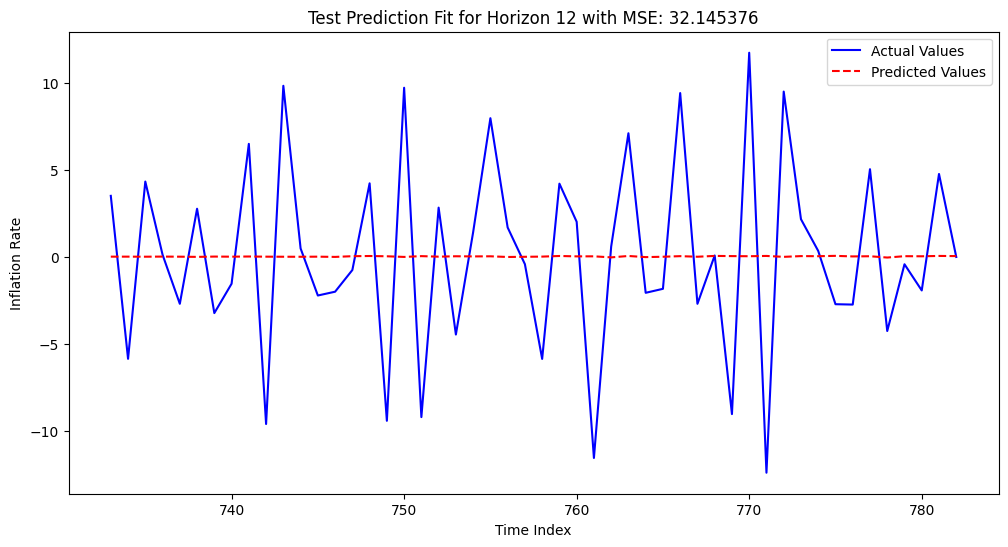

In [35]:
test_mses = {}
for horizon in horizons:
    X_test, y_test = prepare_test_data(train_predictors, train_inflation_rate, test_predictors, test_inflation_rate, n_lags, horizon)
    model_random_forest = models_random_forest[horizon]  # Retrieve the model trained for this specific horizon
    
    y_pred_test = model_random_forest.predict(X_test)
    test_mses[horizon] = mean_squared_error(y_test, y_pred_test)

    end_idx = len(combined_inflation_rate)  
    start_idx = end_idx - 50  

    plt.figure(figsize=(12, 6))
    plt.plot(combined_inflation_rate.index[start_idx:end_idx], y_test, label='Actual Values', color='blue')
    plt.plot(combined_inflation_rate.index[start_idx:end_idx], y_pred_test, label='Predicted Values', linestyle='--', color='red')
    plt.title(f"Test Prediction Fit for Horizon {horizon} with MSE: {test_mses[horizon]:.6f}")
    plt.xlabel('Time Index')
    plt.ylabel('Inflation Rate')
    plt.legend()
    plt.show()

### 2.6 Gradient Boosting

#### 2.6.1 Model Training and In-Sample Fitting

Training XGBoost model for 1-month ahead prediction:
Training with params: {'learning_rate': 0.01, 'max_depth': 3}
Average MSE for current params: 0.0009
Training with params: {'learning_rate': 0.01, 'max_depth': 5}
Average MSE for current params: 0.0010
Training with params: {'learning_rate': 0.1, 'max_depth': 3}
Average MSE for current params: 0.0008
Training with params: {'learning_rate': 0.1, 'max_depth': 5}
Average MSE for current params: 0.0009
Best parameters found: {'learning_rate': 0.1, 'max_depth': 3} with MSE: 0.0008


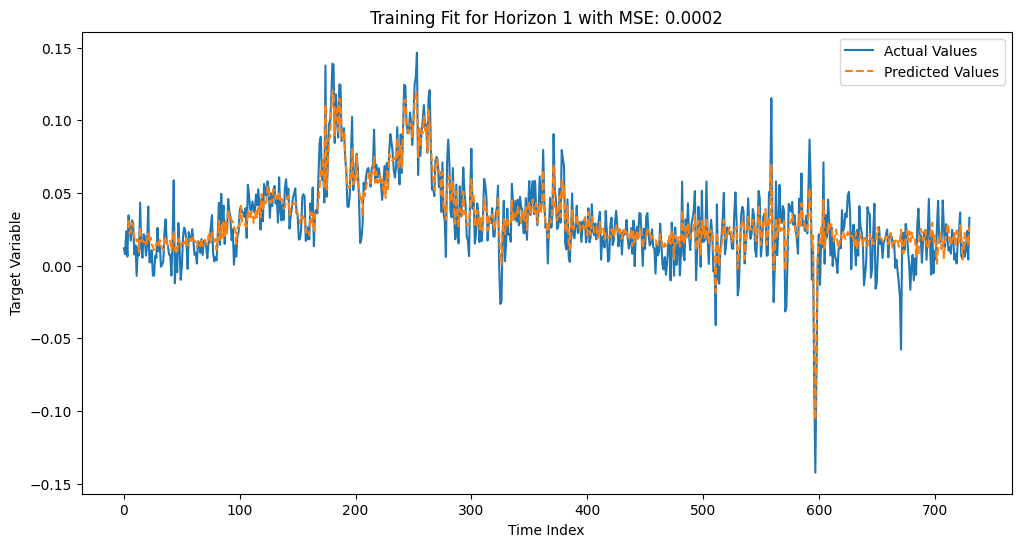

Horizon 1: Best MSE on Cross-Validation: 0.0008, Best Params: {'learning_rate': 0.1, 'max_depth': 3}
Horizon 1: Training Set MSE: 0.0002
Training XGBoost model for 3-month ahead prediction:
Training with params: {'learning_rate': 0.01, 'max_depth': 3}
Average MSE for current params: 0.0009
Training with params: {'learning_rate': 0.01, 'max_depth': 5}
Average MSE for current params: 0.0009
Training with params: {'learning_rate': 0.1, 'max_depth': 3}
Average MSE for current params: 0.0008
Training with params: {'learning_rate': 0.1, 'max_depth': 5}
Average MSE for current params: 0.0008
Best parameters found: {'learning_rate': 0.1, 'max_depth': 5} with MSE: 0.0008


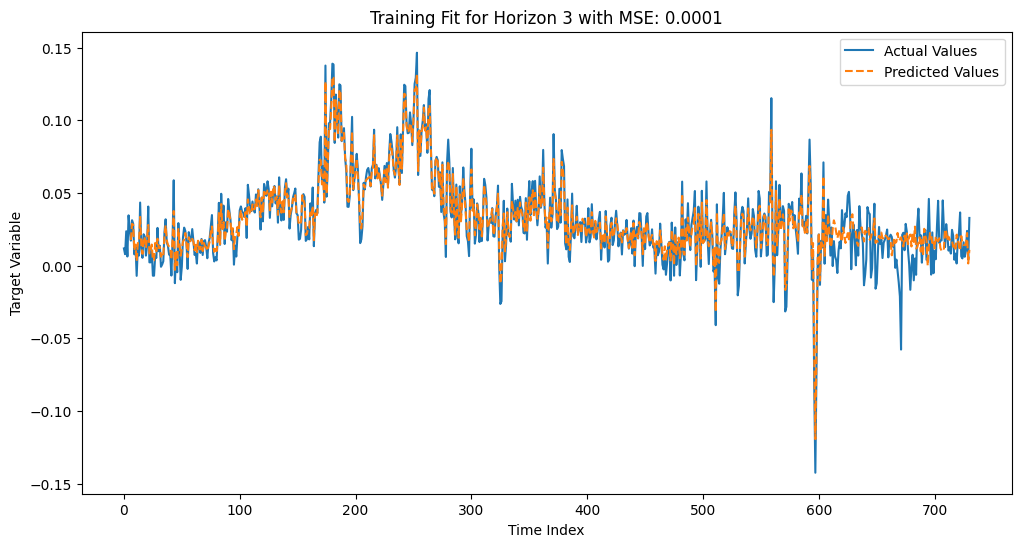

Horizon 3: Best MSE on Cross-Validation: 0.0008, Best Params: {'learning_rate': 0.1, 'max_depth': 5}
Horizon 3: Training Set MSE: 0.0001
Training XGBoost model for 12-month ahead prediction:
Training with params: {'learning_rate': 0.01, 'max_depth': 3}
Average MSE for current params: 0.0010
Training with params: {'learning_rate': 0.01, 'max_depth': 5}
Average MSE for current params: 0.0010
Training with params: {'learning_rate': 0.1, 'max_depth': 3}
Average MSE for current params: 0.0009
Training with params: {'learning_rate': 0.1, 'max_depth': 5}
Average MSE for current params: 0.0010
Best parameters found: {'learning_rate': 0.1, 'max_depth': 3} with MSE: 0.0009


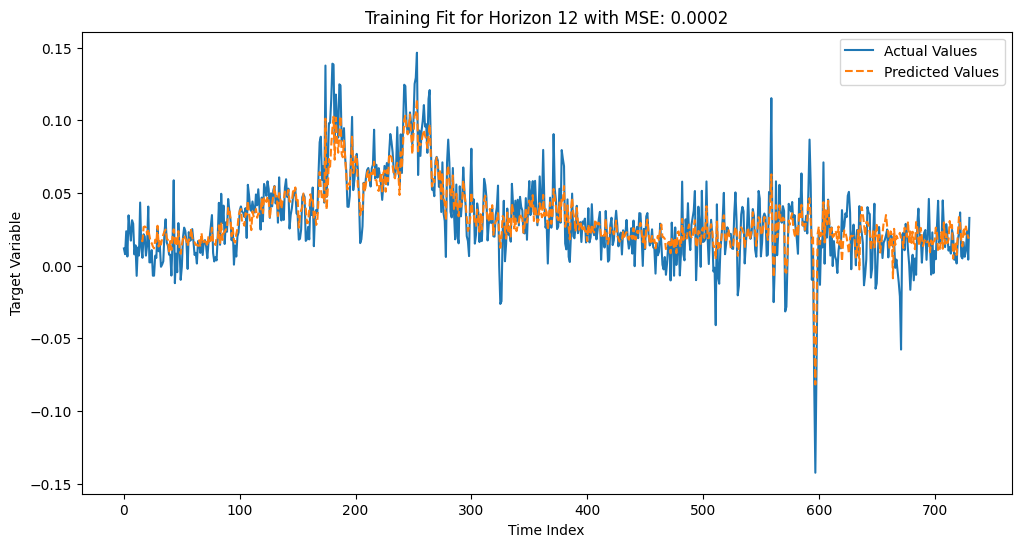

Horizon 12: Best MSE on Cross-Validation: 0.0009, Best Params: {'learning_rate': 0.1, 'max_depth': 3}
Horizon 12: Training Set MSE: 0.0002


In [39]:
import xgboost as xgb

def train_xgboost(X, y, n_splits, param_grid):
    # Initialize Time Series cross-validator
    tscv = TimeSeriesSplit(n_splits=n_splits)
    best_model = None
    best_mse = float('inf')
    best_params = None

    for params in ParameterGrid(param_grid):
        print(f"Training with params: {params}")
        # Initialize XGBoost regressor with parameters from the grid
        model_gradient_boosting = xgb.XGBRegressor(
            n_estimators=100,  
            learning_rate=params['learning_rate'],
            max_depth=params['max_depth'],
            random_state=42,
            n_jobs=-1,
            eval_metric="rmse",
            early_stopping_rounds=10  # Set early stopping rounds in the constructor
        )
        mse_list = []

        # Perform cross-validation
        for train_idx, test_idx in tscv.split(X):
            X_train, y_train = X[train_idx], y[train_idx]
            X_val, y_val = X[test_idx], y[test_idx]
            eval_set = [(X_val, y_val)]

            model_gradient_boosting.fit(X_train, y_train, eval_set=eval_set, verbose=False)
            y_pred = model_gradient_boosting.predict(X_val)
            # Calculate MSE for the current fold
            mse = mean_squared_error(y_val, y_pred)
            mse_list.append(mse)

        # Calculate the average MSE across all folds
        avg_mse = np.mean(mse_list)
        if avg_mse < best_mse:
            best_mse = avg_mse
            best_model = model_gradient_boosting
            best_params = params

        print(f"Average MSE for current params: {avg_mse:.4f}")

    print(f"Best parameters found: {best_params} with MSE: {best_mse:.4f}")
    return best_model, best_mse, best_params

# Define parameter grid to search over
param_grid = {
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 5]
}
n_splits = 5
n_lags = 3
horizons = [1, 3, 12]

models_gradient_boosting = {}
mse_scores = {}
best_params = {}

# Iterate over each forecasting horizon
for horizon in horizons:
    print(f"Training XGBoost model for {horizon}-month ahead prediction:")
    # Prepare data using the specified number of lags and the current horizon
    X, y = prepare_data(train_predictors_scaled, train_inflation_rate, n_lags, horizon)
    # Train the model using XGBoost with time series cross-validation
    model_gradient_boosting, mse, params = train_xgboost(X, y, n_splits, param_grid)
    # Store the best model, MSE and parameters for each horizon
    models_gradient_boosting[horizon] = model_gradient_boosting
    mse_scores[horizon] = mse
    best_params[horizon] = params
    
    # Predict on the training set using the best model to calculate in-sample MSE
    y_train_pred = model_gradient_boosting.predict(X)
    train_mse = mean_squared_error(y, y_train_pred)

    # Visualize the fit on the training set
    plt.figure(figsize=(12, 6))
    plt.plot(range(len(train_inflation_rate)), train_inflation_rate, label='Actual Values')
    pred_start = n_lags + horizon
    plt.plot(range(pred_start, pred_start + len(y_train_pred)), y_train_pred, label='Predicted Values', linestyle='--')
    plt.title(f"Training Fit for Horizon {horizon} with MSE: {train_mse:.4f}")
    plt.xlabel('Time Index')
    plt.ylabel('Target Variable')
    plt.legend()
    plt.show()

    # Print results for this horizon
    print(f"Horizon {horizon}: Best MSE on Cross-Validation: {mse:.4f}, Best Params: {params}")
    print(f"Horizon {horizon}: Training Set MSE: {train_mse:.4f}")

#### 2.6.2 Pseudo Out-of-Sample Prediction

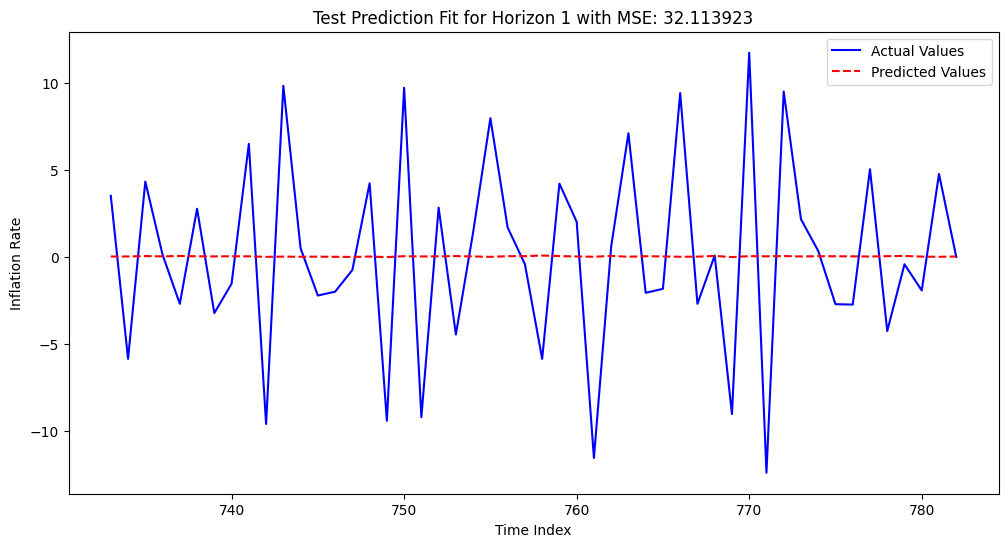

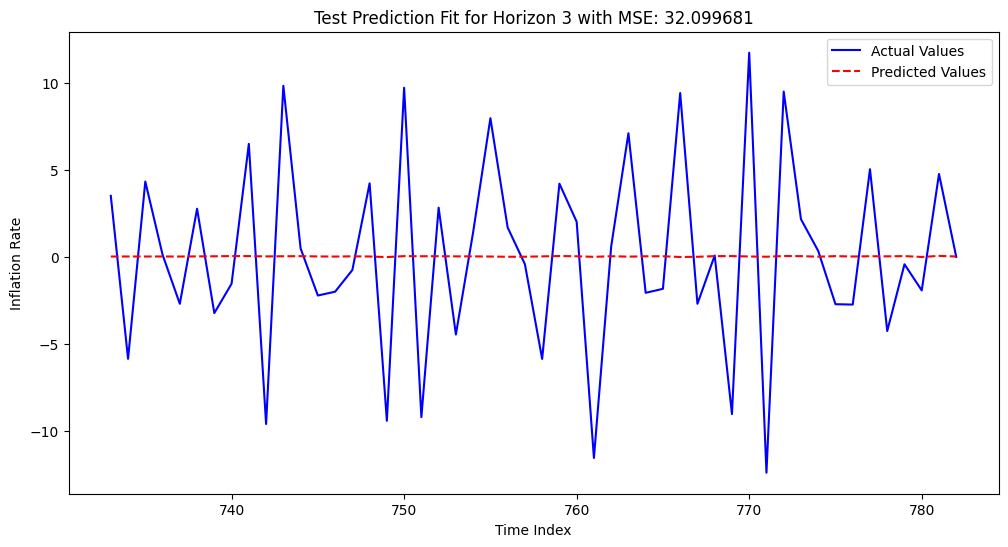

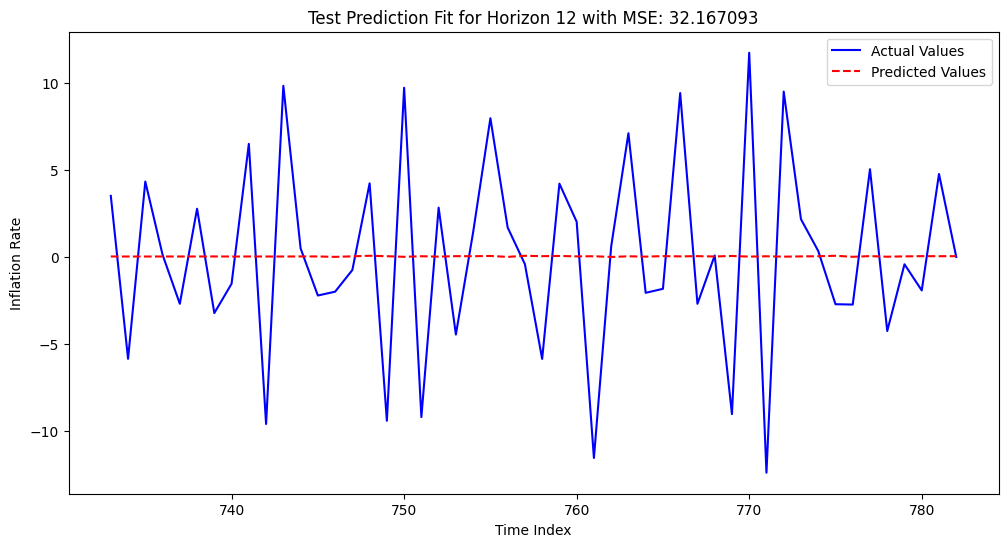

In [41]:
test_mses = {}
for horizon in horizons:
    X_test, y_test = prepare_test_data(train_predictors, train_inflation_rate, test_predictors, test_inflation_rate, n_lags, horizon)
    model_gradient_boosting = models_gradient_boosting[horizon]  # Retrieve the model trained for this specific horizon
    
    y_pred_test = model_gradient_boosting.predict(X_test)
    test_mses[horizon] = mean_squared_error(y_test, y_pred_test)

    end_idx = len(combined_inflation_rate)  
    start_idx = end_idx - 50  

    plt.figure(figsize=(12, 6))
    plt.plot(combined_inflation_rate.index[start_idx:end_idx], y_test, label='Actual Values', color='blue')
    plt.plot(combined_inflation_rate.index[start_idx:end_idx], y_pred_test, label='Predicted Values', linestyle='--', color='red')
    plt.title(f"Test Prediction Fit for Horizon {horizon} with MSE: {test_mses[horizon]:.6f}")
    plt.xlabel('Time Index')
    plt.ylabel('Inflation Rate')
    plt.legend()
    plt.show()